# Result for **ResNet18+Cifar10**
### This notebook is for seed $42$. The results in the paper are the average of $5$ times with seeds in $[1, 19, 31, 42, 80]$

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import os
import random
import numpy as np
import pandas as pd
import copy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

## Models

In [2]:
"""resnet in pytorch
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output


def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet18_copy():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## Prepare data

In [3]:
def create_loaders(dataset_name, n_workers, batch_size):
    train_data, test_data = load_data(dataset_name)
    train_loader_workers = dict()
    n = len(train_data)
    
    # preparing iterators for workers
    indices = np.arange(n)
    np.random.shuffle(indices)
    a = np.int(np.floor(n / n_workers))
    top_ind = a * n_workers
    seq = range(a, top_ind, a)
    split = np.split(indices[:top_ind], seq)
    b = 0
    for ind in split:
        train_loader_workers[b] = DataLoader(Subset(train_data, ind), batch_size=batch_size, shuffle=True)
        b = b + 1
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader_workers, test_loader


def load_data(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)

    elif dataset_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_data = datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
        test_data = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    elif dataset_name == 'cifar100':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        train_data = datasets.CIFAR100(root='./data', train=True,
                                       download=True, transform=transform_train)
        test_data = datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test)

    else:
        raise ValueError(dataset_name + ' is not known.')

    return train_data, test_data

## Parameter and Setup

In [4]:
# Hyperparameters
RANDOM_SEED = 42
lr = 0.01
BATCH_SIZE = 10
NUM_EPOCHS = 30
NUM_WORKERS = 10
D = 10  # compute thread
h = 0.01  # sparse level 99%

if not os.path.exists('result'):
    os.mkdir('result')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cuda


## Functions

In [5]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
def evaluate_accuracy(model, data_iter, device):
    correct = 0
    for image, label in data_iter:
        image, label = image.to(device), label.to(device)
        output = model(image)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(data_iter.dataset)
    return accuracy


# Top_k sparse
def prep_grad(x):
    x_flat = torch.unsqueeze(x, 0).flatten()
    dim = x.shape
    d = x_flat.shape[0]
    return x_flat, dim, d


def top_k_opt(x, h):
    """
    :param x: vector to sparsify
    :param h: density
    :return: compressed vector
    """
    x, dim, d = prep_grad(x)
    # number of coordinates kept
    r = int(np.maximum(1, np.floor(d * h)))
    # positions of top_k coordinates
    _, ind = torch.topk(torch.abs(x), r)
    mask = torch.zeros_like(x)
    mask[ind] = 1
    t = mask * x
    t = t.reshape(dim)
    return t


def compt(old, new):
    result = 0.0
    for i in range(len(old)):
        result += ((old[i].view(-1) - new[i].view(-1)) ** 2).sum().item()
    return result


def adjust_lr(epoch_input):
    lr_ad, lr_th = 0.01, 0.01
    if epoch_input >= 20:
        lr_ad = 0.001
    if epoch_input > 20:
        lr_th = 0.001
    return lr_ad, lr_th

# SASG

In [6]:
print("SASG  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
model_copy = resnet18_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    
    # adjust learning_rate
    lr, lr_thead = adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)
    
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)
                        grad_agg[p_id] += Tk_sparse
                        error_worker[w_id][p_id] = g - Tk_sparse
                        grad_worker[w_id][p_id] = Tk_sparse
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (lr_thead * (NUM_WORKERS ** 2))
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1
                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))
          
print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SASG-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SASG-res-cifar10-iter.csv", encoding='gbk')

SASG  lr:0.01--h:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
Element_parameter_sparse: 111723
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.6271
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.8239
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.2648
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.1663
Epoch: 001/030 | Batch 0500/0500 | Cost: 0.6823
epoch 1, skip_num 0, loss 1.4529, train acc 47.486%, test acc 62.610%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 1.2413
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.5484
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.2059
Epoch: 002/030 | Batch 0400/0500 | Cost: 0.4741
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.4950
epoch 2, skip_num 9, loss 0.9308, train acc 67.454%, test acc 75.850%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.5324
Epoch: 003/030 | Batch 0200/0500 | Cos

Epoch: 024/030 | Batch 0200/0500 | Cost: 0.3654
Epoch: 024/030 | Batch 0300/0500 | Cost: 0.0208
Epoch: 024/030 | Batch 0400/0500 | Cost: 0.0180
Epoch: 024/030 | Batch 0500/0500 | Cost: 0.0598
epoch 24, skip_num 3001, loss 0.1084, train acc 96.568%, test acc 91.680%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.4215
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.2252
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.0138
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.0388
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0243
****************************************************************************************************
Iter_num: 12500 Test_acc 92.01 Skip_round: 31270 Comm_round: 93730
****************************************************************************************************
epoch 25, skip_num 3009, loss 0.1020, train acc 96.802%, test acc 92.010%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0331
Epoch: 026/030 | Batch 0200/0500 | Co

# LASG

In [7]:
print("LASG  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
model_copy = resnet18_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

state_dict = [0 for col in range(NUM_WORKERS)]
NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False
for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    
    # adjust learning_rate
    lr, lr_thead = adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach()
                        grad_agg[p_id] += g
                        grad_worker[w_id][p_id] = g
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (lr_thead * (NUM_WORKERS ** 2))
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1
                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach()
                            grad_agg[p_id] += g
                            grad_worker[w_id][p_id] = g
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()

            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"LASG-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"LASG-res-cifar10-iter.csv", encoding='gbk')

LASG  lr:0.001--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.7659
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.4933
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.6559
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.8860
Epoch: 001/030 | Batch 0500/0500 | Cost: 1.6803
epoch 1, skip_num 0, loss 1.7549, train acc 36.730%, test acc 43.470%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 1.9076
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.3421
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.5174
Epoch: 002/030 | Batch 0400/0500 | Cost: 0.7951
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.6016
epoch 2, skip_num 0, loss 1.2107, train acc 57.036%, test acc 64.660%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.7909
Epoch: 003/030 | Batch 0200/0500 | Cost: 1.4459
Epoch: 003/030 | Batch 0300/05

Epoch: 024/030 | Batch 0300/0500 | Cost: 0.0598
Epoch: 024/030 | Batch 0400/0500 | Cost: 0.0510
****************************************************************************************************
Iter_num: 11900 Test_acc 92.05 Skip_round: 7313 Comm_round: 111687
****************************************************************************************************
Epoch: 024/030 | Batch 0500/0500 | Cost: 0.0271
epoch 24, skip_num 1560, loss 0.1175, train acc 96.100%, test acc 92.040%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.4641
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.3206
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.0292
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.1273
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0104
epoch 25, skip_num 1618, loss 0.1104, train acc 96.380%, test acc 91.820%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0374
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.1940
Epoch: 026/030 | Batch 0300/0500 | Co

# Sparse

In [8]:
print("Sparse  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    # adjust learning_rate
    lr, _= adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                    Tk_sparse = top_k_opt(g, h)
                    grad_agg[p_id] += Tk_sparse
                    error_worker[w_id][p_id] = g - Tk_sparse
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"Sparse-res-cifar10.csv", encoding='gbk')


list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"Sparse-res-cifar10-iter.csv", encoding='gbk')

Sparse  lr:0.001--h:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.6553
Epoch: 001/030 | Batch 0200/0500 | Cost: 0.9916
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.9955
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.2333
Epoch: 001/030 | Batch 0500/0500 | Cost: 0.9191
epoch 1, loss 1.4469, train acc 47.566%, test acc 64.650%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 0.7892
Epoch: 002/030 | Batch 0200/0500 | Cost: 0.8064
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.3882
Epoch: 002/030 | Batch 0400/0500 | Cost: 1.0509
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.2324
epoch 2, loss 0.9298, train acc 67.536%, test acc 75.340%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.8624
Epoch: 003/030 | Batch 0200/0500 | Cost: 0.5237
Epoch: 003/030 | Batch 0300/0500 | Cost: 0.1

Epoch: 024/030 | Batch 0400/0500 | Cost: 0.0062
Epoch: 024/030 | Batch 0500/0500 | Cost: 0.0351
epoch 24, loss 0.0806, train acc 97.378%, test acc 92.140%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.0635
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.0427
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.0573
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.1550
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0062
epoch 25, loss 0.0772, train acc 97.464%, test acc 92.230%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0019
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.0041
Epoch: 026/030 | Batch 0300/0500 | Cost: 0.0547
Epoch: 026/030 | Batch 0400/0500 | Cost: 0.1533
Epoch: 026/030 | Batch 0500/0500 | Cost: 0.0351
epoch 26, loss 0.0738, train acc 97.632%, test acc 92.270%
EPOCH:  27 learning rate:  0.001
Epoch: 027/030 | Batch 0100/0500 | Cost: 0.0140
Epoch: 027/030 | Batch 0200/0500 | Cost: 0.0304
Epoch: 027/030 | Batch 0300/0500 | Cost: 0.0653
Epoc

# SGD

In [9]:
print("Dis-SGD  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    # adjust learning_rate
    lr, _= adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    grad_agg[p_id] += lr * p.grad.data.clone().detach()
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SGD-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SGD-res-cifar10-iter.csv", encoding='gbk')

Dis-SGD  lr:0.001--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.5711
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.7554
Epoch: 001/030 | Batch 0300/0500 | Cost: 2.0835
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.6002
Epoch: 001/030 | Batch 0500/0500 | Cost: 1.2747
epoch 1, loss 1.8287, train acc 34.600%, test acc 55.200%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 0.8878
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.3493
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.6958
Epoch: 002/030 | Batch 0400/0500 | Cost: 1.3677
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.8068
epoch 2, loss 1.2500, train acc 55.572%, test acc 61.420%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.6893
Epoch: 003/030 | Batch 0200/0500 | Cost: 1.2035
Epoch: 003/030 | Batch 0300/0500 | Cost: 0.3772
Epo

epoch 24, loss 0.1098, train acc 96.264%, test acc 92.020%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.1842
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.0269
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.1695
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.1533
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0137
epoch 25, loss 0.1052, train acc 96.462%, test acc 92.130%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0127
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.0082
Epoch: 026/030 | Batch 0300/0500 | Cost: 0.1978
Epoch: 026/030 | Batch 0400/0500 | Cost: 0.2362
Epoch: 026/030 | Batch 0500/0500 | Cost: 0.0482
epoch 26, loss 0.1021, train acc 96.594%, test acc 92.040%
EPOCH:  27 learning rate:  0.001
Epoch: 027/030 | Batch 0100/0500 | Cost: 0.0974
Epoch: 027/030 | Batch 0200/0500 | Cost: 0.2017
Epoch: 027/030 | Batch 0300/0500 | Cost: 0.1389
Epoch: 027/030 | Batch 0400/0500 | Cost: 0.0452
Epoch: 027/030 | Batch 0500/0500 | Cost: 0.0065
epoc

## Plotting

original communication number: 1000


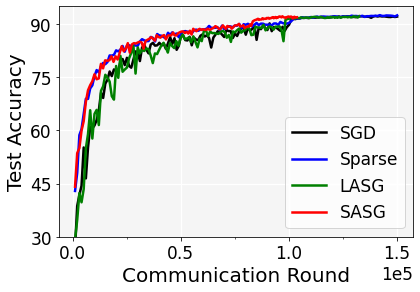

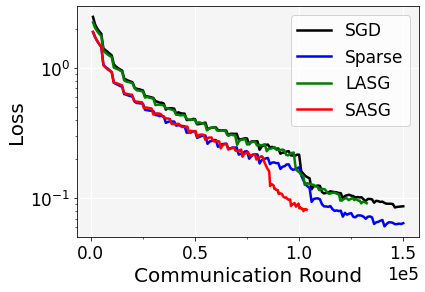

In [10]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

SASG_data = pd.read_csv("./result/"+"SASG-res-cifar10-iter.csv")
LASG_data = pd.read_csv("./result/"+"LASG-res-cifar10-iter.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-res-cifar10-iter.csv")
sgd_data = pd.read_csv("./result/"+"SGD-res-cifar10-iter.csv")

SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    comm_round_SASG.append(comm_num_SASG - SASG_skip[i])
    comm_round_LASG.append(comm_num_LASG - LASG_skip[i])
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)

font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}
plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='both', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5)
plt.plot(comm_round_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5)
plt.plot(comm_round_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(50000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(25000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(30, 95)
ymajorLocator = MultipleLocator(15)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(15)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"test_res_cifar10.png", dpi=600)
plt.show()


plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5)
plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5)
plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(50000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(25000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_res_cifar10.png", dpi=600)
plt.show()